In [111]:
import random
from timeit import default_timer as timer

MAX_TIME = 600
MAX_ELEMENTS_AT_ONCE = 100000

class puzzle_field:    
    
    def __init__(self, puzzle, history):
        self.puzzle = [x[:] for x in puzzle]
        self.history = history

    def __lt__(self, other):
        return self.heuristic() < other.heuristic()

    def print(self, puzzle = -1):
        if puzzle == -1:
            puzzle = self.puzzle
        for row in puzzle:
            for cell in row:
                print(cell, end=" ")
            print()

    def get_empty_cell_position(self):
        row_index = 0
        column_index = 0
        for row in self.puzzle:
            for cell in row:
                if cell == 0:
                    return row_index, column_index
                else:
                    column_index += 1
            column_index = 0
            row_index += 1

    def get_children(self, is_history_used):
        puzzle_children = []
        for i in range(1, 5):
            flag = True
            child = self.move_tile_puzzle(i)
            if child != -1:
                history = self.history+[self.puzzle]
                if is_history_used:
                    for prev in history:
                        if self.are_puzzles_equal(child, prev):
                            flag = False
                            break
                if flag:
                    puzzle_children.append(puzzle_field(child, history))
        return puzzle_children

    def are_puzzles_equal(self, puzzle1, puzzle2):
        for j in range(len(puzzle1)):
            for k in range(len(puzzle1[j])):
                if puzzle1[j][k] != puzzle2[j][k]:
                    return False
        return True

    def move_tile_puzzle(self, direction=-1):
        row_index, column_index = self.get_empty_cell_position()
        puzzle = [x[:] for x in self.puzzle]

        if direction == 1:
            if row_index < 1:
                return -1
            puzzle[row_index][column_index] = puzzle[row_index - 1][column_index]
            puzzle[row_index - 1][column_index] = 0

        elif direction == 2:
            if column_index > len(puzzle[row_index]) - 2:
                return -1
            puzzle[row_index][column_index] = puzzle[row_index][column_index + 1]
            puzzle[row_index][column_index + 1] = 0

        elif direction == 3:
            if row_index > len(puzzle) - 2:
                return -1
            puzzle[row_index][column_index] = puzzle[row_index + 1][column_index]
            puzzle[row_index + 1][column_index] = 0

        elif direction == 4:
            if column_index < 1:
                return -1
            puzzle[row_index][column_index] = puzzle[row_index][column_index - 1]
            puzzle[row_index][column_index - 1] = 0

        else:
            puzzle = self.move_tile_puzzle(random.randint(1, 4))
            while puzzle == -1:
                puzzle = self.move_tile_puzzle(random.randint(1, 4))

        return puzzle

    def is_puzzle_solved(self):
        size = len(self.puzzle) * len(self.puzzle[0])
        num = 1
        for row in self.puzzle:
            for cell in row:
                if cell != num:
                    return False
                num = (num + 1) % size
        return True

    def shuffle(self, steps=5):
        child = []
        for _ in range(steps):
            child = self.move_tile_puzzle()
            self.puzzle = child
        return child
    
    def heuristic(self):
        size = len(self.puzzle) * len(self.puzzle[0])
        num = 1
        heuristic = 0
        for row in range(len(self.puzzle)):
            for column in range(len(self.puzzle[row])):
                actual_row, actual_column = self.find_pos(num)
                heuristic = heuristic + abs(actual_row-row) + abs(actual_column-column)
                num = (num+1) % size
        return heuristic

    def find_pos(self, num):
        for row in range(len(self.puzzle)):
            for column in range(len(self.puzzle[row])):
                if self.puzzle[row][column] == num:
                    return row, column

basic_puzzle = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 0]
]

initial_puzzle = puzzle_field(basic_puzzle, [])
initial_puzzle.shuffle(10)
initial_puzzle.print()


0 2 3 
1 4 6 
7 5 8 


In [112]:
def BFS(start, is_history_used):
    start_timer = timer()
    max_state_num_at_once = 0
    queue = list()
    num_of_generated_nodes = 1
    queue.append(start)
    while queue:
        if timer() - start_timer < MAX_TIME and len(queue) < MAX_ELEMENTS_AT_ONCE:
            max_state_num_at_once = max(max_state_num_at_once, len(queue))
            node = queue.pop(0)
            if node.is_puzzle_solved():
                break
            for child in node.get_children(is_history_used):
                num_of_generated_nodes+=1
                queue.append(child)
        else:
            break

    if not node.is_puzzle_solved():
        node = None

    return node, num_of_generated_nodes, max_state_num_at_once

In [113]:
result, b, c = BFS(initial_puzzle, True)
print("\nRoute: ")
for puzzle in result.history:
    initial_puzzle.print(puzzle)
    print("------")
result.print()


Route: 
0 2 3 
1 4 6 
7 5 8 
------
1 2 3 
0 4 6 
7 5 8 
------
1 2 3 
4 0 6 
7 5 8 
------
1 2 3 
4 5 6 
7 0 8 
------
1 2 3 
4 5 6 
7 8 0 


**Informated search**

In [114]:
### Queue with priority
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item):
        heapq.heappush(self.elements, item)
    
    def get(self):
        return heapq.heappop(self.elements)[1]

In [115]:
### A Star Search algorithm
def a_star_search(start, is_history_used):
    start_timer = timer()
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    counter = 1
    current = None
    max_queue_size = 1
    
    while not frontier.empty():
        if timer() - start_timer < MAX_TIME and len(frontier.elements) < MAX_ELEMENTS_AT_ONCE:
            max_queue_size = max(max_queue_size, len(frontier.elements))
            current = frontier.get()

            if current.is_puzzle_solved():
                break

            for next in current.get_children(is_history_used):
                new_cost = cost_so_far[current] + 1
                if next not in cost_so_far or new_cost < cost_so_far[next]:
                    cost_so_far[next] = new_cost
                    priority = new_cost + next.heuristic()
                    frontier.put((priority, next))
                    came_from[next] = current
                    counter += 1   
        else:
            break
    
    if not current.is_puzzle_solved():
        current = None

    return current, counter, max_queue_size

In [116]:
### Run Search
result, b, c = a_star_search(initial_puzzle, False)
print("\nRoute: ")
for puzzle in result.history:
    initial_puzzle.print(puzzle)
    print("------")
result.print()



Route: 
0 2 3 
1 4 6 
7 5 8 
------
1 2 3 
0 4 6 
7 5 8 
------
1 2 3 
4 0 6 
7 5 8 
------
1 2 3 
4 5 6 
7 0 8 
------
1 2 3 
4 5 6 
7 8 0 


In [117]:
# BFS vs A*
shuffle_num = 28
input_field = []
time = [[],[],[],[]]
nodes_generated = [[],[],[],[]]
max_state_num_at_once = [[],[],[],[]]
route_len = [[],[],[],[]]
result = [[],[],[],[]]

def add_results(index, field, length, max_state, time_):
    if field:
        time[index].append(time_)
        nodes_generated[index].append(length)
        max_state_num_at_once[index].append(max_state)
        route_len[index].append(len(field.history))
        result[index].append(field)
    else:
        time[index].append(time_)
        nodes_generated[index].append(length)
        max_state_num_at_once[index].append(max_state)
        route_len[index].append(None)
        result[index].append(None)

def test_algorithm(algorithm, input, flag, index):
    start_timer = timer()
    field, length, max_state = algorithm(input, flag)
    end_timer = timer()
    add_results(index, field, length, max_state, end_timer-start_timer)


for i in range(20):
    
    input_field.append(puzzle_field(basic_puzzle, [])) 
    if i % 5 == 0:
        shuffle_num += 2

    input_field[-1].shuffle(shuffle_num)
    flag = False
    index = 0
    for _ in range(2):
        test_algorithm(BFS, input_field[-1], flag, index)
        flag = True
        print("BFS time:", "{:.4f}".format(time[index][-1]))
        index+=1        

    flag = False
    for _ in range(2):
        test_algorithm(a_star_search, input_field[-1], flag, index)
        flag = True
        print("A* time: ", "{:.4f}".format(time[index][-1]))
        index+=1        
    
    print("Iterations done: ", i+1)

    


BFS time: 0.1697
BFS time: 0.0090
A* time:  0.0030
A* time:  0.0012
Iterations done:  1
BFS time: 0.0255
BFS time: 0.0035
A* time:  0.0024
A* time:  0.0007
Iterations done:  2
BFS time: 0.2452
BFS time: 0.0104
A* time:  0.0015
A* time:  0.0008
Iterations done:  3
BFS time: 0.0047
BFS time: 0.0012
A* time:  0.0009
A* time:  0.0004
Iterations done:  4
BFS time: 0.0000
BFS time: 0.0000
A* time:  0.0001
A* time:  0.0001
Iterations done:  5
BFS time: 0.0508
BFS time: 0.0048
A* time:  0.0051
A* time:  0.0009
Iterations done:  6
BFS time: 0.0080
BFS time: 0.0017
A* time:  0.0010
A* time:  0.0005
Iterations done:  7
BFS time: 0.2812
BFS time: 0.0114
A* time:  0.0046
A* time:  0.0010
Iterations done:  8
BFS time: 0.3651
BFS time: 0.0127
A* time:  0.0132
A* time:  0.0025
Iterations done:  9
BFS time: 0.0326
BFS time: 0.0041
A* time:  0.0054
A* time:  0.0008
Iterations done:  10
BFS time: 0.0001
BFS time: 0.0001
A* time:  0.0001
A* time:  0.0001
Iterations done:  11
BFS time: 0.0003
BFS time: 0.0

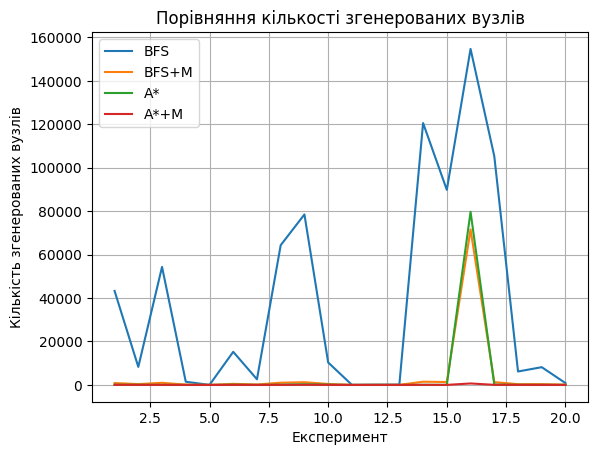

In [123]:
import matplotlib.pyplot as plt

plt.xlabel('Експеримент')
plt.ylabel('Кількість згенерованих вузлів')
plt.title('Порівняння кількості згенерованих вузлів')
x = [i+1 for i in range(20)]
for i in range(4):
    plt.plot(x, nodes_generated[i])
plt.legend(["BFS", "BFS+M", "A*", "A*+M"])
plt.grid()
#plt.savefig('a_star_ucs.svg')
plt.show()

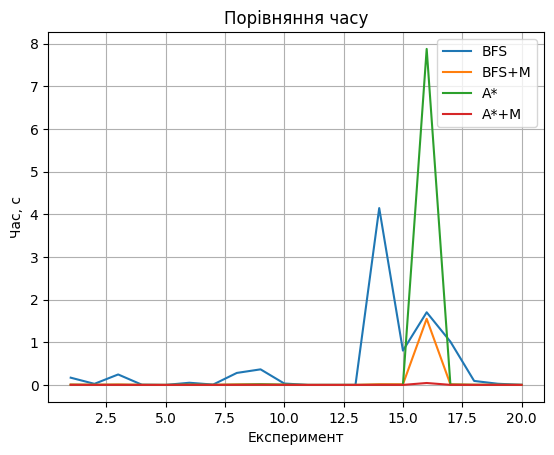

In [122]:
import matplotlib.pyplot as plt

plt.xlabel('Експеримент')
plt.ylabel('Час, с')
plt.title('Порівняння часу')
x = [i+1 for i in range(20)]
for i in range(4):
    plt.plot(x, time[i])
plt.legend(["BFS", "BFS+M", "A*", "A*+M"])
plt.grid()
#plt.savefig('a_star_ucs.svg')
plt.show()

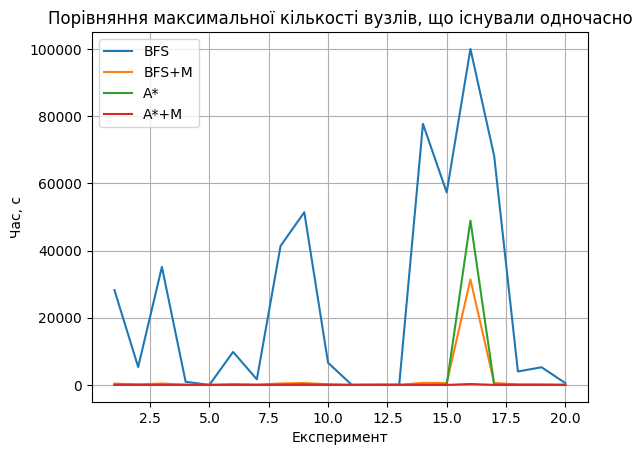

In [124]:
import matplotlib.pyplot as plt

plt.xlabel('Експеримент')
plt.ylabel('Час, с')
plt.title('Порівняння максимальної кількості вузлів, що існували одночасно')
x = [i+1 for i in range(20)]
for i in range(4):
    plt.plot(x, max_state_num_at_once[i])
plt.legend(["BFS", "BFS+M", "A*", "A*+M"])
plt.grid()
#plt.savefig('a_star_ucs.svg')
plt.show()

In [120]:
import tabulate

def print_route_len(num):
    if num:
        return num
    return "NF"

data = []
algorithm_names = ["BFS", "BFS+M", "A*", "A*+M"]
start_field_data = []
for i in range(20):
    for j in range(3):
        start_field_data.append([])
        for k in range(3):
            start_field_data[-1].append(input_field[i].puzzle[j][k])
    start_field_data.append(["", "", ""])

for i in range(20):
    if i%5==0:
        data.append(["№", "", "", "", "Алгоритм", "К-сть кроків", "Час, с", "К-сть згенерованих вузлів", "Макс. к-сть одноч. вузлів"])
    number = i+1
    for j in range(4):        
        data.append([number, start_field_data[i*4+j][0], start_field_data[i*4+j][1], start_field_data[i*4+j][2], algorithm_names[j], print_route_len(route_len[j][i]), "{:.4f}".format(time[j][i]), nodes_generated[j][i], max_state_num_at_once[j][i]])
        number = ""

table = tabulate.tabulate(data, tablefmt='html')
table

№,,,,Алгоритм,К-сть кроків,"Час, с",К-сть згенерованих вузлів,Макс. к-сть одноч. вузлів
1,1,3,8,BFS,10,0.1697,43283,28222
,4,2,5,BFS+M,10,0.0090,872,378
,7,6,0,A*,10,0.0030,108,68
,,,,A*+M,10,0.0012,40,19
2,4,1,0,BFS,8,0.0255,8301,5335
,2,6,3,BFS+M,8,0.0035,375,160
,7,5,8,A*,8,0.0024,77,49
,,,,A*+M,8,0.0007,25,12
3,1,6,0,BFS,10,0.2452,54341,35134
,5,3,2,BFS+M,10,0.0104,986,416


In [127]:
data_average = []

data_average.append(["Алгоритм", "Час, с", "К-сть згенерованих вузлів", "Макс. к-сть одноч. вузлів"])

for j in range(4):        
    data_average.append([algorithm_names[j], "{:.4f}".format(sum(time[j])/len(time[j])), sum(nodes_generated[j])/len(nodes_generated[j]), sum(max_state_num_at_once[j])/len(max_state_num_at_once[j])])
    number = ""

table = tabulate.tabulate(data_average, tablefmt='html')
table

Алгоритм,"Час, с",К-сть згенерованих вузлів,Макс. к-сть одноч. вузлів
BFS,0.4486,38214.2,24683.5
BFS+M,0.0830,4121.3,1801.4
A*,0.3964,4061.0,2494.0
A*+M,0.0030,58.5,25.35
